# Eclipsing Binaries
Using EBs to determine the nature of the TESS Inter-Sector Variance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

transits = pd.read_csv("eb_transits.csv", index_col=["TIC", "sector"])
transits

camera  ccd  npix_tpf  npx_ap     target_x     target_y  \
TIC        sector                                                            
25078924   1            4    1       121      13  1029.434697   411.298232   
           2            4    1       121      12  1934.557536    83.511880   
           3            4    2       121      12   724.969178   213.476553   
           4            4    2       121      14  1511.272862   767.780975   
           5            4    2       121      11  1950.884472  1617.195043   
...                   ...  ...       ...     ...          ...          ...   
1551345500 57           4    1       121      15   254.023862  1851.361263   
           58           4    4       121      18  1620.491320  1381.675154   
           59           4    4       121      20   951.595941   666.599897   
           60           4    4       121      18    67.184466   347.152200   
           73           4    4       121      18   623.723060   492.760793   

                   crowdsap  flfrcsap     period  duration        btjd0  \
TIC        sector                                                         
25078924   1       0.946844  0.898606   0.904677      0.05  1325.957921   
           2       0.948318  0.895164   0.900331      0.33  1354.874323   
           3       0.946689  0.892067   0.905286      0.33  1386.424625   
           4       0.946857  0.911520   0.913546      0.33  1411.698569   
           5       0.952000  0.873196   0.904174      0.33  1439.057580   
...                     ...       ...        ...       ...          ...   
1551345500 57      0.296951  0.906522  31.590579      0.33  2853.520053   
           58      0.295133  0.921084  31.590579      0.33  2897.973321   
           59      0.294373  0.932109  31.590579      0.33  2921.216697   
           60      0.296055  0.917567  31.590579      0.33  2946.955845   
           73      0.295170  0.912422  31.590579      0.33  3294.543095   

                   flux_median  e_flux_median  primary_depth  primary_std  
TIC        sector                                                          
25078924   1         7618.0520      90.695270     417.878261     0.324359  
           2         7683.0137     159.670140     317.419024     0.155578  
           3         7790.7600     204.624510     560.791309     0.183027  
           4         7865.1333     148.710480     354.257818     0.174449  
           5         7450.7430      87.027306     454.599974     0.154907  
...                        ...            ...            ...          ...  
1551345500 57       16457.6210      46.926556      69.503923     0.935306  
           58       16551.8160      49.281326      87.025823     0.976435  
           59       16940.8400      42.489635      62.365786     0.956747  
           60       16610.2770      52.311226      75.640787     0.956902  
           73       16516.4220      82.264410     115.229639     0.941421  

[5619 rows x 15 columns]

## Transit Depth vs. Baseline Flux
If the ISV is additive, it will affect both in- and out-of-transit flux equally as a constant offset in electrons. The transit depths (the difference between in- and out-of-transit flux) should therefore be unaffected, and the same value for every sector.

If, however, the transit depth depends on the baseline flux (i.e., brighter sectors have deeper transits), then the ISV is multiplicative.

Here we plot the target depth vs. median sector flux for each target, saving plots as we go. We'll show a typical example below.

### Transit Depth vs. Flux, per target

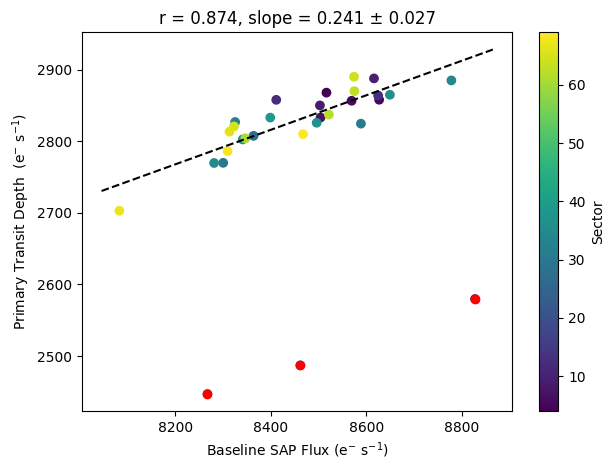

In [2]:
%matplotlib inline
from scipy.stats import linregress

tr = transits.copy()
tics = tr.reset_index().TIC.unique()

sigma = 3
for i, tic in enumerate(tics):
    d = tr.query("TIC == @tic")
        
    xdata = d["flux_median"]
    ydata = d["primary_depth"]

    slope, intercept, rvalue, pvalue, stderr = linregress(xdata, ydata)
    yfit = slope*xdata + intercept
    error = abs(ydata - yfit)
    rms_scatter = np.sqrt(np.median(error**2))
    sub_data = d.loc[error/rms_scatter < sigma]
    outliers = d.loc[error/rms_scatter >= sigma]
    
    xdata = sub_data["flux_median"]
    ydata = sub_data["primary_depth"]

    slope, intercept, rvalue, pvalue, stderr = linregress(xdata, ydata)
    yfit = slope*xdata + intercept
    error = abs(ydata - yfit)
    rms_scatter = np.sqrt(np.median(error**2))
    outliers = pd.concat([outliers, sub_data.loc[error/rms_scatter >= sigma]])
    sub_data = sub_data.loc[error/rms_scatter < sigma]

    xdata = sub_data["flux_median"]
    ydata = sub_data["primary_depth"]
    slope, intercept, rvalue, pvalue, stderr = linregress(xdata, ydata)

    plt.figure()
    plt.scatter("flux_median", "primary_depth", data=d.reset_index(), c="sector")
    plt.xlabel("Baseline SAP Flux (e$^{-}$ s$^{-1}$)")
    plt.ylabel("Primary Transit Depth  (e$^{-}$ s$^{-1}$)")
    plt.colorbar(label="Sector")    
    xlim = np.array(plt.xlim())
    plt.plot(xlim, slope*xlim + intercept, "k--")
    plt.scatter("flux_median", "primary_depth", data=outliers, c="r")
    plt.title(f"r = {rvalue:.3f}, slope = {slope:.3f} ± {stderr:.3f}")
    plt.tight_layout()
    plt.savefig(f"plots/summary/TIC{tic:010d}.png")
    if i != 3:
        plt.close()
    
    tr = tr.drop(outliers.index)
    tr.loc[tic, "rvalue"] = rvalue
    tr.loc[tic, "slope"] = slope
    tr.loc[tic, "e_slope"] = stderr
    tr.loc[tic, "intercept"] = intercept
    tr.loc[tic, "normalized_median_flux"] = xdata / np.median(xdata)
    tr.loc[tic, "normalized_transit_depth"] = ydata / np.median(ydata)

In our example, transit depth correlates strongly with median flux, suggesting the variance is multiplicative rather than additive. Most of the other examples show this as well, but a few have lots of scatter from crowding or PSF leakage.

Let's now look at a summary plot of all the targets.

### All targets depth vs. flux
Same as above, but now for all targets. Now each target will be distinctly colored, and we'll zoom in a bit. 

I'm plotting things with weak correlation in black. That'll be relevant in the next plot.

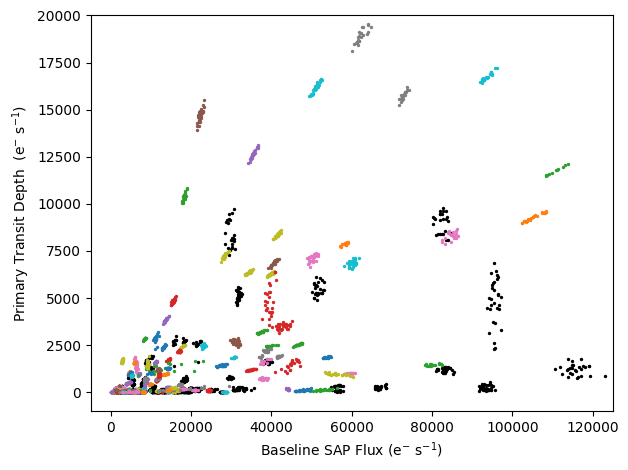

In [3]:
tics = tr.reset_index().TIC.unique()

plt.figure()
good_fits = tr.query("abs(rvalue) >= 0.3")
bad_fits = tr.query("abs(rvalue) < 0.3")

for tic in bad_fits.reset_index().TIC.unique():
    plt.scatter("flux_median", "primary_depth", data=bad_fits.loc[tic], s=2, c="k")
for tic in good_fits.reset_index().TIC.unique():   
    plt.scatter("flux_median", "primary_depth", data=good_fits.loc[tic], s=2)
    
plt.xlabel("Baseline SAP Flux (e$^{-}$ s$^{-1}$)")
plt.ylabel("Primary Transit Depth  (e$^{-}$ s$^{-1}$)")
plt.xlim(-5000, 125000)
plt.ylim(-1000, 20000)
plt.tight_layout()
#plt.savefig("EB_example.png", dpi=200)

### All targets depth vs. flux, normalized
We can now see clearly that the transit depth strongly depends on the flux, so the TESS Inter-Sector Variance is multiplicative! Brighter targets experience a larger offset from sector to sector.

Now we want to summarize this information, so we will median-divide the x- and y-axes for each target, and plot all examples in a histogram.

Note I'm removing things with weak correlation ($|r| < 0.3$). This is a little bit cherry-picking, but I want to emphasize that basically everything that is correlated has the same flux-dependent variance.

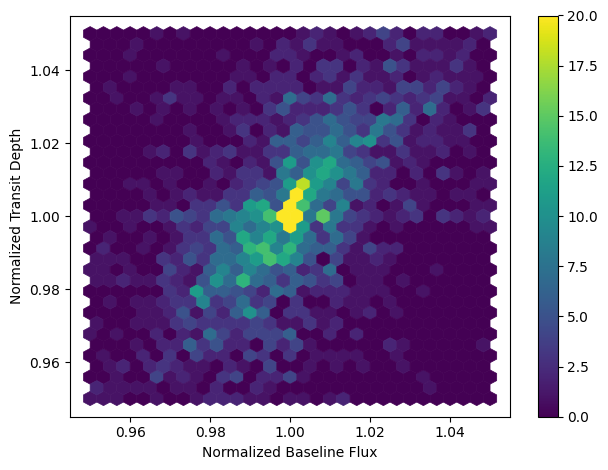

In [4]:
from matplotlib.colors import LogNorm

%matplotlib inline
tics = tr.query("abs(rvalue) >= 0.3").reset_index().TIC.unique()

xdata = []
ydata = []
xpx = []
ypx = []

for tic in tics:
    data = tr.loc[tic]
    flux = data.normalized_median_flux.values
    depth = data.normalized_transit_depth.values
    xdata.extend(flux)
    ydata.extend(depth)
    
plt.figure()
plt.hexbin(xdata, ydata, mincnt=0, gridsize=30, linewidths=0.5, 
    extent=(0.95, 1.05, 0.95, 1.05), vmax=20,
    #norm=LogNorm()
    )
    
plt.xlabel("Normalized Baseline Flux")
plt.ylabel("Normalized Transit Depth")
plt.colorbar()
plt.tight_layout()

### Inter-Sector Variance across the TESS CCDs

Now let's look at the variance in the image plane of camera 4. To get the variance, I'll normalize the median sector flux by the median overall flux for each target. This way, of the median sector flux == median overall flux, variance = 1. If the median sector flux is less, variance < 1, and if the median sector flux is more, variance > 1.

First let's see how the coverage is for the four Camera 4 CCDs.

In [5]:
tr.query("rvalue > 0.3 and camera == 4").value_counts("ccd")

ccd
1    683
2    666
3    661
4    635
Name: count, dtype: int64

We have over 600 targets per CCD, so we can split up the views in ways that are meaningful. 

We'll look at the variance across the camera for all targets, by TESS cycle, and by North and South targets, again saving plots as we go. But let's keep "all" to look at here.

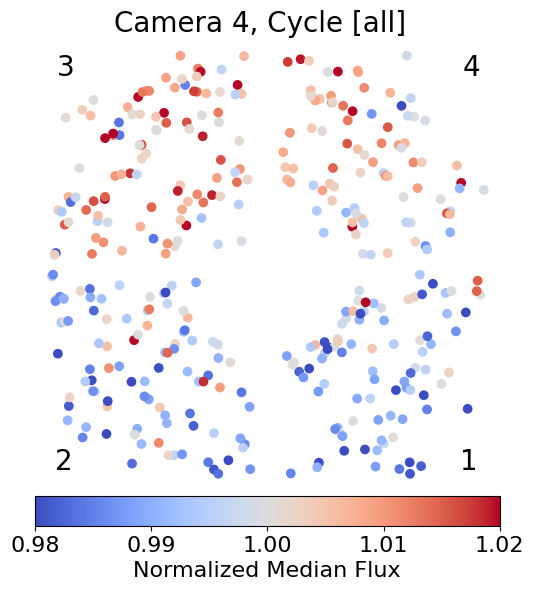

In [6]:
cam = 4
%matplotlib inline
for cycle in [1, 2, 3, 4, 5, "south", "north", "all"]:
    plt.close()
    #%matplotlib inline
    # fig, axs = plt.subplots(2, 2, figsize=(6, 6))
    # ax = axs.flatten()
    
    fig = plt.figure(figsize=(6, 6))
    gs1 = fig.add_gridspec(2, 2, hspace=0, wspace=0, bottom=0.2, top=0.93)
    gs2 = fig.add_gridspec(1, 2, bottom=0.13, top=0.18)
    
    ax1 = fig.add_subplot(gs1[0, 0])
    ax2 = fig.add_subplot(gs1[0, 1])
    ax3 = fig.add_subplot(gs1[1, 0])
    ax4 = fig.add_subplot(gs1[1, 1])
    ax = [ax1, ax2, ax3, ax4]
    cax = fig.add_subplot(gs2[:])
    
    #cycle = "all"
    ccd = [3, 4, 2, 1]
    coords = [
        (0.1, 0.9),
        (0.9, 0.9),
        (0.1, 0.1),
        (0.9, 0.1),]
        
    for i in range(len(ax)):
        c = ccd[i]
        if cycle == 1:
            d = tr.query("rvalue > 0.3 and camera == @cam and ccd==@c and sector <= 13")
        elif cycle == 2:
            d = tr.query("rvalue > 0.3 and camera == @cam and ccd==@c and 14 <= sector <= 26")
        elif cycle == 3:
            d = tr.query("rvalue > 0.3 and camera == @cam and ccd==@c and 27 <= sector <= 39")
        elif cycle == 4:
            d = tr.query("rvalue > 0.3 and camera == @cam and ccd==@c and 40 <= sector <= 55")
        elif cycle == 5:
            d = tr.query("rvalue > 0.3 and camera == @cam and ccd==@c and 56 <= sector <= 69")
        elif cycle == "south":
            d = tr.query("rvalue > 0.3 and camera == @cam and ccd==@c and ((sector <= 13) or (27 <= sector <= 39) or (61 <= sector <= 69))")
        elif cycle == "north":
            d = tr.query("rvalue > 0.3 and camera == @cam and ccd==@c and ((14 <= sector <= 26) or (40 <= sector <= 60))")
        elif cycle == "all":
            d = tr.query("rvalue > 0.3 and camera == @cam and ccd==@c")

        d = d.query("crowdsap > 0.99 and flfrcsap > 0.95").eval("frac = normalized_transit_depth / normalized_median_flux")
        im = ax[i].scatter("target_x", "target_y", c="normalized_median_flux", data=d, cmap="coolwarm", vmin=0.98, vmax=1.02)
        #im = ax[i].scatter("target_x", "target_y", c="frac", data=d, cmap="jet")
        
        if c in [3, 4]:
            ax[i].invert_yaxis()
        elif c in [1, 2]:
            ax[i].invert_xaxis()
    
        ax[i].set_aspect("equal")
        ax[i].text(*coords[i], f"{c}", transform=ax[i].transAxes, ha="center", va="center", fontsize=20)
        ax[i].axis("off")
    
    
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.set_label("Normalized Median Flux", fontsize=16)
    cb.ax.set_xticks([0.98, 0.99, 1, 1.01, 1.02])
    cb.ax.tick_params(labelsize=16)
    
    fig.suptitle(f"Camera {cam}, Cycle [{cycle}]", y=0.99, fontsize=20)
    #fig.subplots_adjust(hspace=0, wspace=0, top=0.98)
    #fig.tight_layout()
    plt.savefig(f"plots/camera4/tess_isv_camera4_cycle_{cycle}.png")

The TESS Inter-Sector Variance depends on CCD! And maybe even location within the CCD. 

Why?